## Capstone project, Part 3: Simulating a battery pack built from SCMs
Welcome to the third computer assignment. If you have not already done so, please complete the "Part 1" project before attempting this "Part 3". The concepts of this part (particularly how to use this notebook and submit your results) build on those from the first part. As before, when you have completed your modifications to the sample code that I have provided as a starting point, click on the <b>"Submit Assignment"</b> button to submit your code to the grader.

### Concept
This Jupyter notebook operates in the same way as all of the other Jupyter notebooks that you have used so far in this course. You can type Octave code into notebook cells and execute that code to see how it functions. This allows you to test your code fully before submitting it for grading.

Only one notebook cell is actually graded – the one marked with <code>"% GRADED FUNCTION"</code> in its first line. Do not modify that line – otherwise the grader will not be able to find the correct function for grading.

### Deliverables
The goal of Part 3 of the capstone project is to write an Octave function that simulates a battery pack built from SCMs. You will start with some sample code that simulates a battery pack built from SCMs at a constant temperature. You will modify this code to enable simulation where the temperature changes with time.

The next workbook cell initializes the workspace by loading in a battery cell model file. This will also be done by the grader.

In [1]:
% Initialize workspace, load the E2 circuit model as well as the E2 dynamic data
addpath readonly
load readonly/E2model.mat; % load parameter values already created for the E2 cell
load readonly/E2_DYN_P25.mat; % load raw test data for the E2 cell at 25 degC

% Resample at consistent 1Hz rate.
deltaT = 1; 
time = DYNData.script1.time - DYNData.script1.time(1);    
t = (2000:deltaT:2500); % select short segment to speed up simulation
voltage = interp1(time,DYNData.script1.voltage,t);
current = interp1(time,DYNData.script1.current,t);
time = t;

The next cell contains the code that you must modify. As is, it simulates a battery pack built from SCMs for a constant temperature. You must modify this function so that it simulates the pack for a time-varying temperature profile. 

In this notebook cell, change only the lines between <code>"% BEGIN MODIFYING CODE AFTER THIS"</code> and <code>"% FINISH MODIFYING CODE BEFORE THIS"</code>. In particular, do not modify the first comment <code>"% GRADED FUNCTION ..."</code>, and do not modify the function inputs, outputs, or name.

In [2]:
 
% function [vpack,vcell,icell,zcell,qcell,rcell] = simSCMTemp(Ns,Np,current,temp,deltaT,model)
%
% Simulate series-connected-module packs (cells are connected in series
% to make modules; these modules are connected in parallel to make packs).
% Note: This function must work for models having a single R-C pair. It is
% not required to work for models having multiple R-C pairs.
%
% Ns - number of cells connected in series to make a module
% Np - number of modules connected in parallel in each pack
% current - battery pack current, where (+) is discharge. Size is N x 1.
% temp  - temperature (degC). Size is N x 1 (all cells at same temperature).
% deltaT = sampling interval in data (s)
% model - standard model structure
% delta - variability vector: variable initial SOC if delta(1)==1; 
%                         variable total capacity if delta(2)==1;
%                         variable series resistance if delta(3)==1;
%
% vpack - battery pack voltage. Size is N x 1.
% vcell - individual cell voltages. Size is N x Ns x Np
% icell - individual cell currents. Size is N x Ns x Np
% zcell - individual cell states of charge. Size is N x Ns x Np
% qcell - individual cell capacities. Size is N x Ns x Np
% rcell - individual cell series resistances. Size is N x Ns x Np

function [vpack,vcell,icell,zcell,qcell,rcell] = simSCMTemp_old(Ns,Np,current,temp,deltaT,model,delta) %#ok<FNDEF>

  % Force current to be column vector in case user entered data incorrectly
  current = current(:); N = length(current); temp = temp(:);
  % Initialize function outputs
  vpack = zeros(N,1); vcell = zeros(N,Ns,Np); icell = zeros(N,Ns,Np);
  zcell = zeros(N,Ns,Np); qcell = zeros(N,Ns,Np); rcell = zeros(N,Ns,Np);
  
  % Do some error checking on the function inputs
  Nr = length(getParamESC('RCParam',25,model)); % number of R-C pairs.
  if Nr ~= 1,
    error('This code does not work for models having multiple R-C pairs.');
  end
  if length(temp) ~= N,
    error('Input "temp" vector not the correct dimension.');
  end
  
  % Initialize states for ESC cell model
  if delta(1),
    z = reshape(linspace(0.3,0.7,Ns*Np),Ns,Np); % Different initial SOCs
  else
    z = 0.5*ones(Ns,Np);
  end
  irc = zeros(Ns,Np);
  h   = zeros(Ns,Np);

  % BEGIN MODIFYING CODE AFTER THIS
  
  T = temp(1); % sample code uses only single temperature -- you will need to change this!
  
  % The code reproduced below as a starting point for you is modified from
  % "simSCM.m".
  %
  % Get model parameters from model structure -- notice that these retreive
  % parameter values for only a single temperature. You will need to change
  % this to load parameter values for all temperatures in temp.
  
  % Default initialization for cells within the pack
  q  = getParamESC('QParam',T,model)*ones(Ns,Np); 
  rc = exp(-deltaT./abs(getParamESC('RCParam',T,model)))'*ones(Ns,Np);
  r  = (getParamESC('RParam',T,model))';
  m  = getParamESC('MParam',T,model)*ones(Ns,Np);
  g  = getParamESC('GParam',T,model)*ones(Ns,Np);
  r0 = getParamESC('R0Param',T,model)*ones(Ns,Np); 
  rt = 0.000125; % 125 microOhm resistance for each tab

  % How to modify capacity at any temperature if that input option is set... 
  % Don't change this functionality since the grader assumes it.
  if delta(2), 
    q = reshape(linspace(0.95,1.05,Ns*Np),Ns,Np).*q; 
  end
  % How to modify resistances at any temperature if that input option is set...
  % Don't change this functionality since the grader assumes it.
  if delta(3),
    r0 = reshape(linspace(0.95,1.05,Ns*Np),Ns,Np).*r0; 
  end
  r0 = r0 + 2*rt; % add tab resistance to cell resistance

  % Okay... now to simulate pack performance using ESC cell model.
  for k = 1:N,
    v = OCVfromSOCtemp(z,T,model); % get OCV for each cell: Ns * Np matrix
    v = v + m.*h - r.*irc; % add in capacitor voltages and hysteresis

    V = (sum(sum(v,1)./sum(r0,1),2)-current(k))./sum(1./sum(r0,1),2); % Bus V
    ik = (sum(v,1)-repmat(V,1,Np))./sum(r0,1); % 1*Np cell currents
    ik = repmat(ik,Ns,1); % Ns*Np cell currents

    z = z - (1/3600)*ik./q;  % Update each cell SOC
    irc = rc.*irc + (1-rc).*ik; % Update capacitor voltages
    fac = exp(-abs(g.*ik)./(3600*q));
    h = fac.*h + (fac-1).*sign(ik); % Update hysteresis voltages

    vpack(k)     = V; % Store pack voltage
    vcell(k,:,:) = v - ik.*r0; % Store cell voltages
    zcell(k,:,:) = z; % Store cell SOCs
    icell(k,:,:) = ik; % Store cell currents
    qcell(k,:,:) = q; % Store cell capacities
    rcell(k,:,:) = r0; % Store cell resistances
  end % for k

  % FINISH MODIFYING CODE BEFORE THIS

end
 

In [3]:
% GRADED FUNCTION (do not modify this line)

% function [vpack,vcell,icell,zcell,qcell,rcell] = simSCMTemp(Ns,Np,current,temp,deltaT,model)
%
% Simulate series-connected-module packs (cells are connected in series
% to make modules; these modules are connected in parallel to make packs).
% Note: This function must work for models having a single R-C pair. It is
% not required to work for models having multiple R-C pairs.
%
% Ns - number of cells connected in series to make a module
% Np - number of modules connected in parallel in each pack
% current - battery pack current, where (+) is discharge. Size is N x 1.
% temp  - temperature (degC). Size is N x 1 (all cells at same temperature).
% deltaT = sampling interval in data (s)
% model - standard model structure
% delta - variability vector: variable initial SOC if delta(1)==1; 
%                         variable total capacity if delta(2)==1;
%                         variable series resistance if delta(3)==1;
%
% vpack - battery pack voltage. Size is N x 1.
% vcell - individual cell voltages. Size is N x Ns x Np
% icell - individual cell currents. Size is N x Ns x Np
% zcell - individual cell states of charge. Size is N x Ns x Np
% qcell - individual cell capacities. Size is N x Ns x Np
% rcell - individual cell series resistances. Size is N x Ns x Np

function [vpack,vcell,icell,zcell,qcell,rcell] = simSCMTemp(Ns,Np,current,temp,deltaT,model,delta) %#ok<FNDEF>

  % Force current to be column vector in case user entered data incorrectly
  current = current(:); N = length(current); temp = temp(:);
  % Initialize function outputs
  vpack = zeros(N,1); vcell = zeros(N,Ns,Np); icell = zeros(N,Ns,Np);
  zcell = zeros(N,Ns,Np); qcell = zeros(N,Ns,Np); rcell = zeros(N,Ns,Np);
  
  % Do some error checking on the function inputs
  Nr = length(getParamESC('RCParam',25,model)); % number of R-C pairs.
  if Nr ~= 1,
    error('This code does not work for models having multiple R-C pairs.');
  end
  if length(temp) ~= N,
    error('Input "temp" vector not the correct dimension.');
  end
  
  % Initialize states for ESC cell model
  if delta(1),
    z = reshape(linspace(0.3,0.7,Ns*Np),Ns,Np); % Different initial SOCs
  else
    z = 0.5*ones(Ns,Np);
  end
  irc = zeros(Ns,Np);
  h   = zeros(Ns,Np);

  % BEGIN MODIFYING CODE AFTER THIS
 
  rt = 0.000125; % 125 microOhm resistance for each tab

  % Collect parameters for each temperature
  G = nan(N, 1);
  M = nan(N, 1);
  R = nan(N, 1);
  RCfact = nan(N, 1);
  for k = 1 : N,
    G(k)      = getParamESC('GParam',  temp(k), model);
    M(k)      = getParamESC('MParam',  temp(k), model);
    R(k)      = getParamESC('RParam',  temp(k), model);
    RCfact(k) = exp(- deltaT ./ abs(getParamESC('RCParam', temp(k), model)));
  end
  
  % Okay... now to simulate pack performance using ESC cell model.
  for k = 1:N,
  
    qk = getParamESC('QParam', temp(k),model)*ones(Ns, Np);
    if delta(2),
      qk = qk + (qk.*reshape(linspace(-0.05,0.05, Ns*Np), Ns, Np));
    end
    qcell(k,:,:) = qk;
    
    rk = getParamESC('R0Param', temp(k),model)*ones(Ns, Np);
    if delta(3),
      rk = rk + (rk.*reshape(linspace(-0.05,0.05, Ns*Np), Ns, Np));
    end
    rk = rk + 2*rt;
    rcell(k,:,:) = rk;
  
    % Given the dynamic status at time k, compute the internal voltage at time k for each cell (NsxNp)
    v = OCVfromSOCtemp(z, temp(k), model) - (irc*R(k)) + (M(k)*h);

    % Compute the voltage of each SCM at time k (1x1)
    V = (sum(sum(v,1)./sum(rk,1), 2) - current(k)) ./ sum(1./sum(rk,1), 2);
    vpack(k) = V; % Store pack voltage
    
    % Compute the currents through each cell at time k (NsxNp) 
    ik = (sum(v,1)-repmat(V,1,Np))./sum(rk,1);  
    ik = repmat(ik,Ns,1);
    icell(k,:,:) = ik;
    
    % Hence the voltage of each cell
    vc = v - ik.*rk;
    vcell(k,:,:) = vc;

    % Known the current flowing in each cell at time k, compute the state of charge at time k+1
    z = z - (ik./qk)*(deltaT/3600);
    zcell(k,:,:) = z;
    
    % Compute the dynamic state at time k+1
    irc = irc*RCfact(k) + ((1 - RCfact(k)) * ik);
 
    % Update hysteresis voltages at time k+1
    fac = exp( - deltaT * abs((G(k)*ik) ./(3600 * qk)));
    h = (fac.*h) + ((fac - 1).*sign(ik));

  end % for k

  if any(rcell < 0)
    error("Negative resistance!")
  end
  if any(qcell < 0)
    error("Negative capacity!")
  end
  
  % FINISH MODIFYING CODE BEFORE THIS

end
% END GRADED FUNCTION

After pressing < shift >< enter > to input the Jupyter notebook cell, above, wait until the "In [*]" on your screen to the left of the notebook cell changes to "In [#]" where "#" is some number. You cannot use the function until Octave has finished scanning it.

You can test your code, as is demonstrated below. You can also refer back to the Jupyter notebook used in lesson 2.4.5 to see other testing that you can do.

In [4]:
% Execute simCell to determine voltage and other internal states/variables

%temp = 25*ones(size(current)); % for now, use constant 25 degC temperature.
temp = linspace(25,45,length(current)); % uncomment to simulate temperature ramp 

Ns = 2; Np = 2; 
[vpack1,vcell1,icell1,zcell1,qcell1,rcell1] = simSCMTemp_old(Ns,Np,current,temp,deltaT,model,[1,1,1]);
[vpack2,vcell2,icell2,zcell2,qcell2,rcell2] = simSCMTemp(Ns,Np,current,temp,deltaT,model,[1,1,1]);

% The grader will input custom pack configurations, pack current, temperature, and combination 
% of delta inputs and compare output to expected output. You will not be told what these custom 
% inputs will be, but you can still test basic functionality and visualize how the cell behavior 
% changes for different temperatures

% For example, for visualization purposes, plot 

% Plot the individual SOC vs. time for all cells in all 
% series PCMs. There is one subplot for each PCM.
t = (0:deltaT:(length(current)-1))/60; 
xplots = round(1.0*ceil(sqrt(Ns))); yplots = ceil(Ns/xplots); means = [];

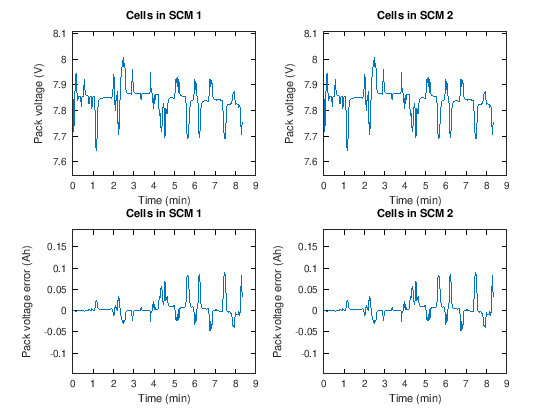

In [5]:
for k = 1:Np,
  zr=vpack2;
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Pack voltage (V)'); xlabel('Time (min)'); 
  zr=zr-vpack1;
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Pack voltage error (Ah)'); xlabel('Time (min)'); 
end

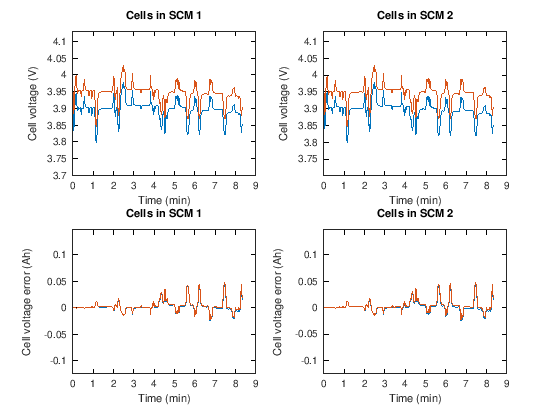

In [6]:
for k = 1:Np,
  zr=squeeze(vcell2(:,:,k));
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Cell voltage (V)'); xlabel('Time (min)'); 
  zr=zr-squeeze(vcell1(:,:,k));
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Cell voltage error (Ah)'); xlabel('Time (min)'); 
end

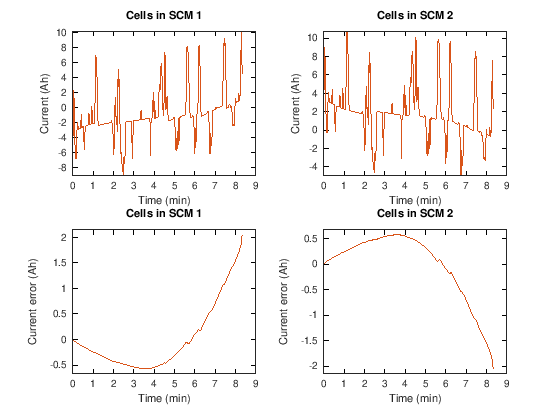

In [7]:
for k = 1:Np,
  zr=squeeze(icell2(:,:,k));
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Current (Ah)'); xlabel('Time (min)'); 
  zr=zr-squeeze(icell1(:,:,k));
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Current error (Ah)'); xlabel('Time (min)'); 
end

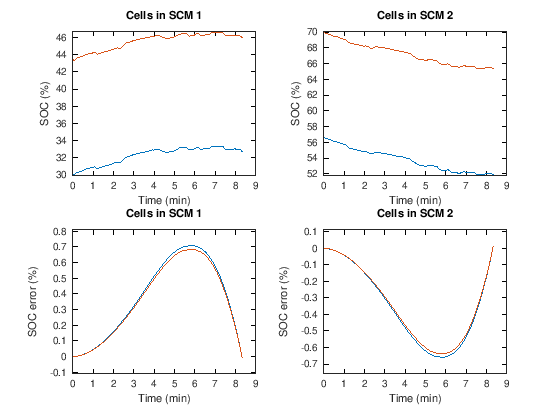

In [8]:
for k = 1:Np,
  zr=squeeze(100*zcell2(:,:,k));
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('SOC (%)'); xlabel('Time (min)'); 
  zr=zr-squeeze(100*zcell1(:,:,k));
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('SOC error (%)'); xlabel('Time (min)'); 
end

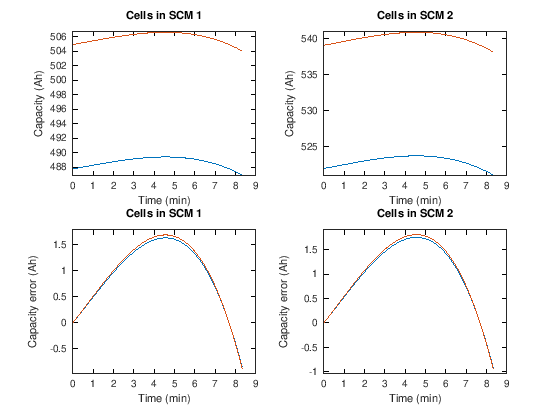

In [9]:
for k = 1:Np,
  zr=squeeze(100*qcell2(:,:,k));
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Capacity (Ah)'); xlabel('Time (min)'); 
  zr=zr-squeeze(100*qcell1(:,:,k));
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Capacity error (Ah)'); xlabel('Time (min)'); 
end

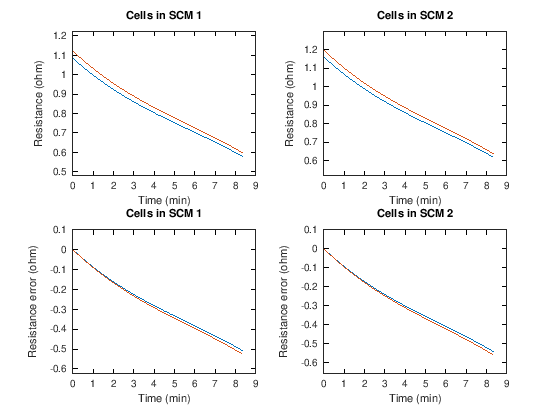

In [10]:
for k = 1:Np,
  zr=squeeze(100*rcell2(:,:,k));
  subplot(yplots+1,xplots,k); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Resistance (ohm)'); xlabel('Time (min)'); 
  zr=zr-squeeze(100*rcell1(:,:,k));
  subplot(yplots+1,xplots,k+xplots); plot(t,zr); axis([0 ceil(max(t)) (min(zr(:))-0.1) (max(zr(:))+0.1)]);
  title(sprintf('Cells in SCM %d',k)); 
  ylabel('Resistance error (ohm)'); xlabel('Time (min)'); 
end

When you are satisfied that your code is executing correctly, click on the "<b>Submit Assignment</b>" button, above.

The assignment will be graded out of a maximum of 20 points possible. Half of the points apply to simulating a battery pack at constant temperature and half apply to simulating a battery pack at a varying temperature.
* 0 points if any output has wrong dimension
* Points for cases having constant temperature input:
  + Points for cases where delta = [0 0 0]:
    + 1 point for correct vpack, vcell, icell, zcell, qcell, rcell
  + Points for cases where delta = [1 0 0]
    + 1 point for correct zcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, qcell, rcell
  + Points for cases where delta = [0 1 0]
    + 1 point for correct qcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, zcell, rcell
  + Points for cases where delta = [0 0 1]
    + 1 point for correct rcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, zcell, qcell
* Points for cases having ramp temperature input:
  + Points for cases where delta = [0 0 0]
    + 1 point for correct vpack, vcell, icell, zcell, qcell, rcell
  + Points for cases where delta = [1 0 0]
    + 1 point for correct zcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, qcell, rcell
  + Points for cases where delta = [0 1 0]
    + 1 point for correct qcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, zcell, rcell
  + Points for cases where delta = [0 0 1]
    + 1 point for correct rcell
    + 1 point for correct vpack
    + 1 point for correct vcell, icell, zcell, qcell